Showing the main code's outputs with jupyter notebook.

## Data Preparation

In [1]:
# Forecasting TOYOTA's Earnings

# importing external packages
import os
import datetime
import numpy as np
import pandas as pd
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import warnings

warnings.simplefilter("ignore")

# importing internal modules
import module_SARIMA
import module_accuracy

In [2]:
# run data_preprocessing.py file to generate data
os.system("python data_preprocessing.py")

# read cleaned data generated from data_preprocessing.py
ts = pd.read_csv("data/cleaned/sample_ts.csv", index_col=0)

ts.head()

,決算期,決算月数,連結基準フラグ,決算種別フラグ,決算発表日,１株当たり利益［累計］,１株当たり利益［３ヵ月］
0,2007-06-01,3,2,21,2007-08-03,153.98,153.98
1,2007-09-01,6,2,22,2007-11-07,295.50,141.51
2,2007-12-01,9,2,23,2008-02-05,439.98,144.47
3,2008-03-01,12,2,10,2008-05-08,540.65,100.67
4,2008-06-01,3,2,21,2008-08-07,112.30,112.30


In [3]:
ts.describe()

,決算月数,連結基準フラグ,決算種別フラグ,１株当たり利益［累計］,１株当たり利益［３ヵ月］
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,7.500000,2.038462,19.000000,305.025192,111.228269
std,3.386826,0.194184,5.295207,243.287100,94.518150
min,3.000000,2.000000,10.000000,-139.130000,-244.180000
25%,5.250000,2.000000,18.250000,110.390000,37.612500
50%,7.500000,2.000000,21.500000,221.645000,135.645000
75%,9.750000,2.000000,22.250000,483.655000,178.367500
max,12.000000,3.000000,23.000000,842.000000,319.010000


In [4]:
# y
y = ts["１株当たり利益［３ヵ月］"]

# train (40) test (12) split
train_size = 40
test_size = 12
y_train = y[:-test_size]
y_test = y[-test_size:]

In [5]:
y_test

40    205.05
41    154.28
42    319.01
43    163.54
44    224.67
45    202.20
46     61.85
47    160.74
48    218.62
49    189.08
50    263.41
51     21.22
Name: １株当たり利益［３ヵ月］, dtype: float64

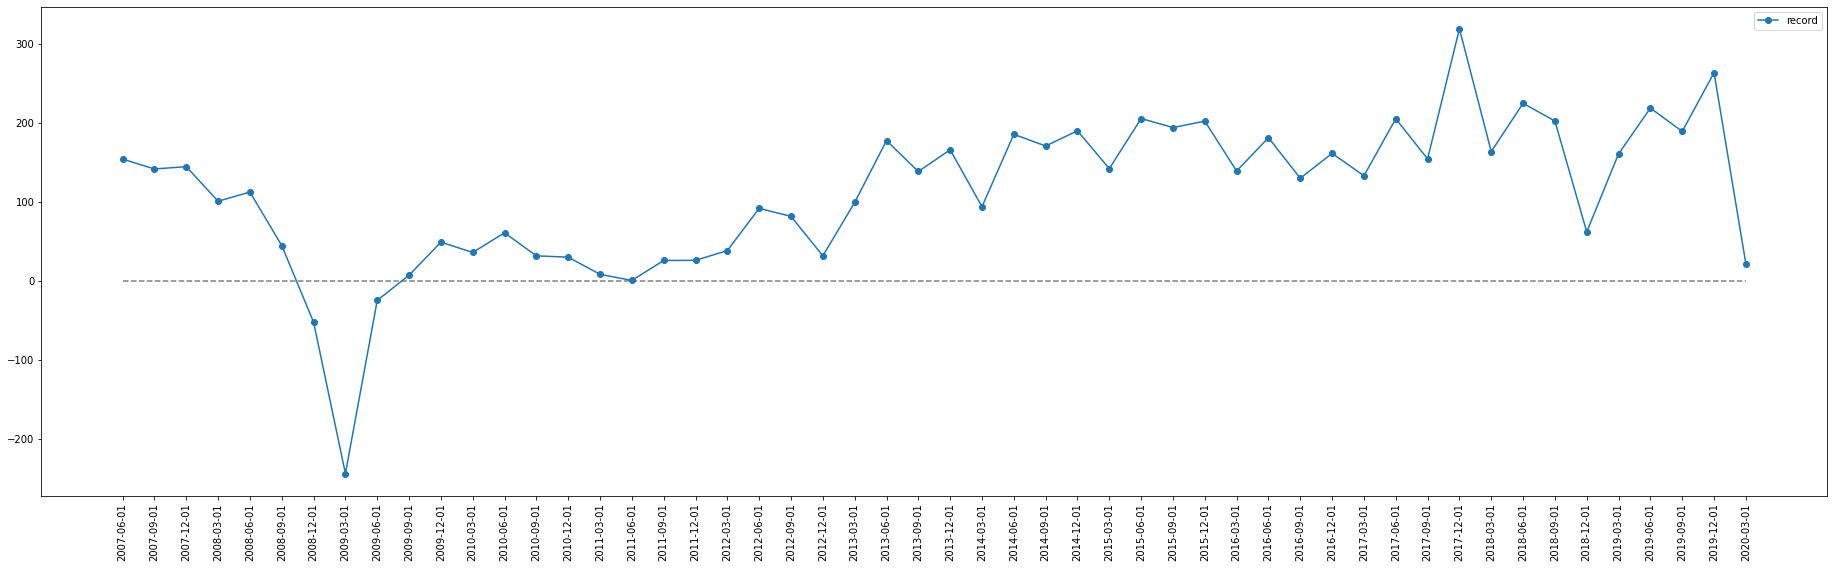

In [6]:
# viz
fig = plt.figure(figsize=(16*2, 9))
ax = fig.add_subplot(111)

ax.plot(ts["決算期"], [0] * len(ts["決算期"]), color="gray", linestyle="--")
ax.plot(ts["決算期"], y, marker="o", label="record")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()

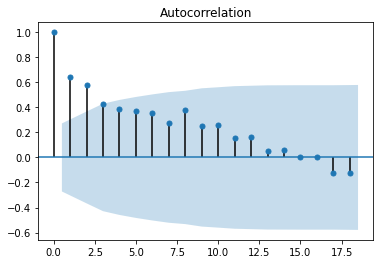

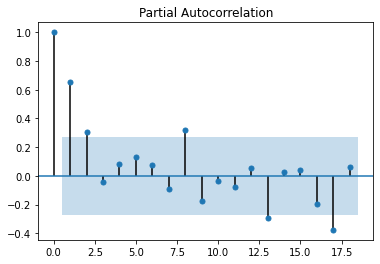

In [7]:
# Check stationality, seasonality, and trends.
# plot ACF
sm.tsa.graphics.plot_acf(y)
plt.show()
# plot PACF
sm.tsa.graphics.plot_pacf(y)
plt.show()

## Model Estimation

### Random walk

In [8]:
# random walk
y_hat_rw = y.shift(1)[-test_size:]
y_hat_rw

40    132.94
41    205.05
42    154.28
43    319.01
44    163.54
45    224.67
46    202.20
47     61.85
48    160.74
49    218.62
50    189.08
51    263.41
Name: １株当たり利益［３ヵ月］, dtype: float64

### SARIMA: Brown & Rozeff
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 1)_4 $

In [9]:
# SARIMA: Brown & Rozeff
y_hat_sarima_br = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_br

40    184.089863
41    173.441442
42    188.928996
43    306.108404
44    216.770260
45    303.897548
46    230.042959
47    132.865969
48    162.881649
49    142.656535
50    166.045922
51    158.774337
dtype: float64

### SARIMA: Griffin
$ (p, d, q) \times (P, D, Q)_S = (0, 1, 1) \times (0, 1, 1)_4 $

In [10]:
# SARIMA: Griffin
y_hat_sarima_g = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_g

40    193.291562
41    175.949928
42    202.113328
43    378.934602
44    285.309464
45    326.715622
46    280.153068
47    187.407108
48    228.005606
49    220.562398
50    258.262331
51    283.176259
dtype: float64

### SARIMA: Foster
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 0)_4 $

In [11]:
# SARIMA: Foster
y_hat_sarima_f = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 0, 4),
    silent=True
)
y_hat_sarima_f

40    177.166887
41    171.508266
42    210.794022
43    327.425389
44    221.066620
45    324.628146
46    233.137151
47     58.358015
48    224.039641
49     61.551715
50    218.468067
51    263.774272
dtype: float64

### Simple 3 layers Multi Layer Perceptron

In [12]:
# 3 Layers Feed Forward Neural Network
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! rolling, expanding window are not implemented yet !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import module_nn

# y, x (lag 4)
y = ts["１株当たり利益［３ヵ月］"].drop([0, 1, 2, 3], axis=0)
y = y.reset_index(drop=True)

x = pd.DataFrame([
    ts["１株当たり利益［３ヵ月］"].shift(1),
    ts["１株当たり利益［３ヵ月］"].shift(2),
    ts["１株当たり利益［３ヵ月］"].shift(3),
    ts["１株当たり利益［３ヵ月］"].shift(4),
]).T.drop([0, 1, 2, 3], axis=0)
x = x.reset_index(drop=True)
x.columns = ["y_(t-1)", "y_(t-2)", "y_(t-3)", "y_(t-4)"]

y.head()

0    112.30
1     44.53
2    -52.49
3   -244.18
4    -24.82
Name: １株当たり利益［３ヵ月］, dtype: float64

In [13]:
x.head()

,y_(t-1),y_(t-2),y_(t-3),y_(t-4)
0,100.67,144.47,141.51,153.98
1,112.30,100.67,144.47,141.51
2,44.53,112.30,100.67,144.47
3,-52.49,44.53,112.30,100.67
4,-244.18,-52.49,44.53,112.30


In [14]:
# Convert data type to torch.tensor
dtype = torch.float
device = torch.device("cpu")

y_tensor = torch.tensor(y.values, dtype=dtype)
x_tensor = torch.tensor(x.values, dtype=dtype)

y_tensor.size(), x_tensor.size()

(torch.Size([48]), torch.Size([48, 4]))

In [15]:
# train test split
y_test_tensor = y_tensor[-test_size:]
y_train_tensor = y_tensor[:-test_size]

x_test_tensor = x_tensor[-test_size:]
x_train_tensor = x_tensor[:-test_size]

print(y_train_tensor.size(), y_test_tensor.size())
print(x_train_tensor.size(), x_test_tensor.size())

torch.Size([36]) torch.Size([12])
torch.Size([36, 4]) torch.Size([12, 4])


In [16]:
# construct, instantiate FFNN
ffnn = module_nn.FFNN(input_features=4, hidden_units=100, output_units=1)
ffnn

FFNN(
  (hidden): Linear(in_features=4, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# Access to ffnn weights
# Initial parameters (weights, bias)
list(ffnn.parameters()) # iteretor, just for printing

[Parameter containing:
 tensor([[ 1.0103e-02, -3.6780e-01, -1.9013e-01,  3.1384e-02],
         [-3.3672e-01, -2.1082e-01,  2.3063e-01, -1.9891e-02],
         [ 7.7777e-02,  3.4267e-01,  2.8789e-01, -3.5655e-01],
         [ 2.2857e-01, -4.7901e-01, -1.8063e-01,  8.6449e-02],
         [ 4.7220e-01, -1.8073e-01,  3.6784e-01, -4.6597e-01],
         [ 1.1828e-01,  4.1314e-01, -2.0070e-01, -4.1783e-01],
         [-1.6563e-01,  3.2858e-01,  6.9419e-02, -1.0865e-01],
         [ 2.3550e-01, -5.7043e-02,  3.7768e-01, -1.9393e-01],
         [ 4.4754e-01, -1.7897e-01,  7.6243e-03, -3.0540e-01],
         [-2.9585e-01,  6.1150e-03, -2.5148e-01, -1.2264e-01],
         [ 5.1164e-02,  1.4512e-01,  1.1833e-01, -2.8541e-01],
         [-2.2038e-01,  2.2821e-01,  2.8072e-01,  2.5014e-01],
         [ 1.2072e-01,  2.4989e-01, -8.2195e-02, -2.3472e-01],
         [ 4.0526e-02,  3.2681e-02,  2.4241e-01,  1.0528e-01],
         [ 1.9480e-01,  1.2356e-01,  2.4075e-01,  1.3746e-02],
         [ 1.2446e-01,  3.6344e-

In [18]:
print(ffnn.hidden.weight.size(), ffnn.hidden.bias.size()) # editable ?
print(ffnn.output.weight.size(), ffnn.output.bias.size())

torch.Size([100, 4]) torch.Size([100])
torch.Size([1, 100]) torch.Size([1])


In [19]:
# Construct loss and optimizer
criterion = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(ffnn.parameters(), lr=1e-2) # link to ffnn parameters

In [20]:
criterion

MSELoss()

In [21]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [22]:
# Learning iteration
num_iteration = 10000

for step in range(num_iteration):
    # Forward pass
    y_pred = ffnn(x_train_tensor)
    # let y_pred be the same size as y
    y_pred = y_pred.squeeze(1)

    # Compute loss
    loss = criterion(y_pred, y_train_tensor) # link to ffnn output
    if step % 1000 == 999:
        print(f"step {step}: loss {loss.item()}")

    # Zero gradients, perform backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step 999: loss 1176.17041015625
step 1999: loss 478.5055847167969
step 2999: loss 210.69796752929688
step 3999: loss 106.66129302978516
step 4999: loss 34.92396545410156
step 5999: loss 21.478925704956055
step 6999: loss 5.668342590332031
step 7999: loss 2.4987504482269287
step 8999: loss 6.0910797119140625
step 9999: loss 0.7403421401977539


In [23]:
# Check trained parameters
list(ffnn.parameters())

[Parameter containing:
 tensor([[ 0.5806,  0.0861, -0.5631, -0.5031],
         [-1.2369, -1.0525,  0.6799,  1.2957],
         [-0.2084,  0.7980,  0.5722, -0.8342],
         [ 0.7481, -0.1795,  0.1145,  0.2343],
         [ 0.8183, -0.6730,  2.4067, -1.6184],
         [ 1.1800,  0.6043,  0.2690, -0.0801],
         [ 1.1754,  1.1056, -0.9072, -0.8821],
         [ 0.8170, -0.2795,  1.6858, -1.2619],
         [ 0.9324, -0.9759,  1.0188,  0.1840],
         [-0.9360,  1.1637, -0.9262, -0.0129],
         [ 0.5504, -0.3513,  1.6076, -1.1796],
         [-0.1026,  0.0597,  0.6785,  1.5086],
         [ 1.1083,  1.2303, -0.9162, -0.8877],
         [ 0.3061,  0.2158,  0.2548,  0.2573],
         [ 1.0843, -1.0234,  0.7834, -0.0828],
         [ 0.2412,  0.4755,  0.4144,  0.2892],
         [ 0.9893,  0.0310, -0.8491, -0.1478],
         [ 0.7170,  0.1658, -0.1759,  0.3838],
         [ 1.4882,  1.3687, -0.3490, -0.4065],
         [ 0.5074, -1.3363,  0.8825, -0.0140],
         [ 0.9549,  1.0562, -1.1035, 

In [24]:
# predict y_hat
y_hat_ffnn = ffnn(x_test_tensor).squeeze().detach().numpy()
y_hat_ffnn

array([211.20163  , 166.9316   , 202.49527  ,  97.37556  ,  81.75092  ,
        46.48052  , 175.83804  ,   1.0539732,  76.94185  , 115.29734  ,
       140.3177   , 167.47725  ], dtype=float32)

## Predition Performance

In [25]:
# compare prediction performance with forecast accuracy indexes
accuracy = pd.DataFrame(
    [
        [
            module_accuracy.MAE(y_test, y_hat_rw),
            module_accuracy.MAE(y_test, y_hat_sarima_br),
            module_accuracy.MAE(y_test, y_hat_sarima_g),
            module_accuracy.MAE(y_test, y_hat_sarima_f),
            module_accuracy.MAE(y_test, y_hat_ffnn)
        ],
        [
            module_accuracy.MAPE(y_test, y_hat_rw),
            module_accuracy.MAPE(y_test, y_hat_sarima_br),
            module_accuracy.MAPE(y_test, y_hat_sarima_g),
            module_accuracy.MAPE(y_test, y_hat_sarima_f),
            module_accuracy.MAPE(y_test, y_hat_ffnn)
        ],
        [
            module_accuracy.MSE(y_test, y_hat_rw),
            module_accuracy.MSE(y_test, y_hat_sarima_br),
            module_accuracy.MSE(y_test, y_hat_sarima_g),
            module_accuracy.MSE(y_test, y_hat_sarima_f),
            module_accuracy.MSE(y_test, y_hat_ffnn)
        ],
        [
            module_accuracy.RMSE(y_test, y_hat_rw),
            module_accuracy.RMSE(y_test, y_hat_sarima_br),
            module_accuracy.RMSE(y_test, y_hat_sarima_g),
            module_accuracy.RMSE(y_test, y_hat_sarima_f),
            module_accuracy.RMSE(y_test, y_hat_ffnn)
        ],
        [
            module_accuracy.RMSPE(y_test, y_hat_rw),
            module_accuracy.RMSPE(y_test, y_hat_sarima_br),
            module_accuracy.RMSPE(y_test, y_hat_sarima_g),
            module_accuracy.RMSPE(y_test, y_hat_sarima_f),
            module_accuracy.RMSPE(y_test, y_hat_ffnn)
        ]
    ],
    index=["MAE", "MAPE", "MSE", "RMSE", "RMSPE"],
    columns=["random walk", "SARIMA: BR", "SARIMA: G", "SARIMA: F", "Multi-Layer Perceptron"]
)
accuracy

,random walk,SARIMA: BR,SARIMA: G,SARIMA: F,Multi-Layer Perceptron
MAE,97.488333,79.626291,91.984736,94.779795,104.883782
MAPE,1.460989,1.024104,1.586353,1.493098,1.126875
MSE,13433.926850,9265.566421,16495.247770,14300.965160,13614.843148
RMSE,115.904818,96.257812,128.433826,119.586643,116.682660
RMSPE,3.384447,2.059803,3.733329,3.424572,2.120968


## Visualize Preditctions

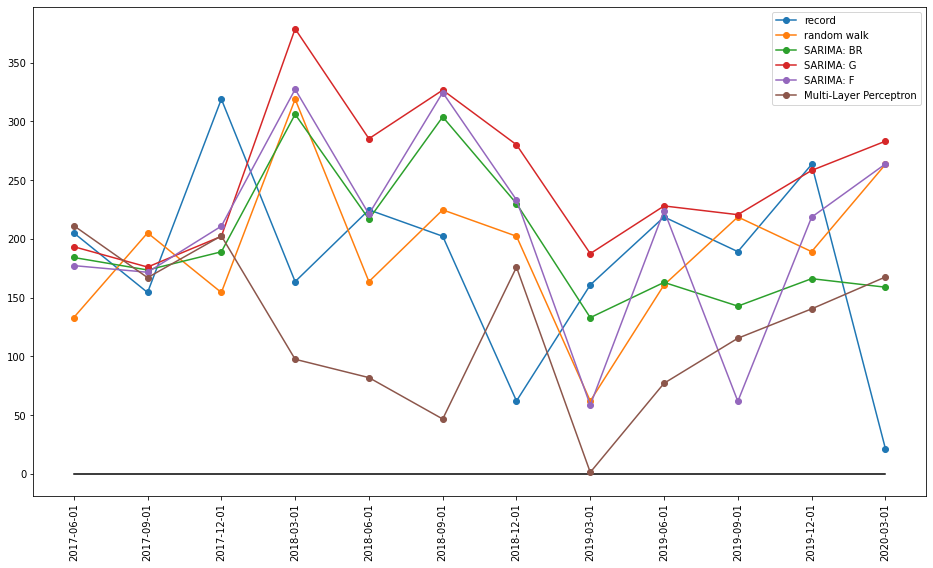

In [26]:
# plot each y_hat series
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(ts["決算期"][train_size:], [0] * len(ts["決算期"][train_size:]), color="black")

ax.plot(ts["決算期"][train_size:], y_test, marker="o", label="record")
    

ax.plot(ts["決算期"][train_size:], y_hat_rw, marker="o", label="random walk")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_br, marker="o", label="SARIMA: BR")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_g, marker="o", label="SARIMA: G")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_f, marker="o", label="SARIMA: F")
ax.plot(ts["決算期"][train_size:], y_hat_ffnn, marker="o", label="Multi-Layer Perceptron")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()